First let's import pylab, Meshoid, and the load_from_snapshot script for loading GIZMO outputs.

In [1]:
%pylab
from Meshoid import Meshoid
from load_from_snapshot import load_from_snapshot
%matplotlib inline

/Users/mgrudic/intelpython3/lib/python3.6/site-packages/IPython/core/pylabtools.py:273: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  import matplotlib


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


Now let's load some of the gas data fields from a FIRE snapshot using load_from_snapshot. In this case we'll perform a density cut at n_H ~ .1 cm^-3 to narrow it down to just the ISM.

In [2]:
rho = load_from_snapshot("Density", 0, "Meshoid/examples/", 600)
density_cut = (rho*300 > .1)
pdata = {}
for field in "Masses", "Coordinates", "SmoothingLength", "Velocities":
    pdata[field] = load_from_snapshot(field, 0, "Meshoid/examples/", 600, particle_mask=np.arange(len(rho))[density_cut])

Finally, before getting to the meshoid stuff we will also center the coordinates and perform a cut in galactocentric radius at 40kpc.

In [3]:
pos = pdata["Coordinates"]
center = np.median(pos,axis=0)
pos -= center
radius_cut = np.sum(pos*pos,axis=1) < 40*40
pos, mass, hsml, v = pos[radius_cut], pdata["Masses"][radius_cut], pdata["SmoothingLength"][radius_cut], pdata["Velocities"][radius_cut]

OK, now let's start by making a map of gas surface density. We can do so by generating a Meshoid object from the particle masses, coordinates, and smoothing lengths, and then calling the SurfaceDensity method. This function is useful for giving kernel-weighted projected quantities on a Cartesion grid of sighlines.

Meshoid can also adaptively compute particle smoothing lengths on-the-fly provided only the coordinates, but it requires a nearest-neighbor search that takes a while so it's best to provide the smoothing length when you can.

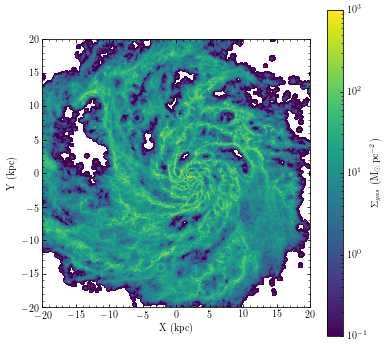

In [4]:
import matplotlib.colors as colors
M = Meshoid(pos, mass, hsml)
rmax = 20
res = 800
X = Y = np.linspace(-rmax, rmax, res)
X, Y = np.meshgrid(X, Y)
fig, ax = plt.subplots(figsize=(6,6))
sigma_gas_msun_pc2 = M.SurfaceDensity(M.m,center=np.array([0,0,0]),size=40.,res=res)*1e4
p = ax.pcolormesh(X, Y, sigma_gas_msun_pc2, norm=colors.LogNorm(vmin=.1,vmax=1e3))
ax.set_aspect('equal')
fig.colorbar(p,label=r"$\Sigma_{gas}$ $(\rm M_\odot\,pc^{-2})$")
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()

Now let's look at the 3D gas density in a slice through the galaxy, using the Slice method.

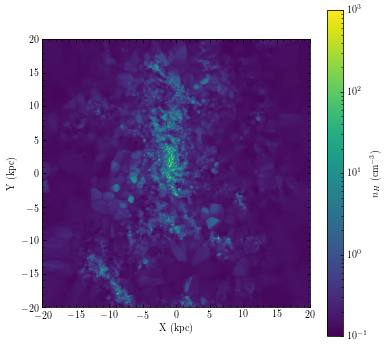

In [5]:
fig, ax = plt.subplots(figsize=(6,6))
density_slice_nHcgs = M.Slice(M.Density(),center=np.array([0,0,0]),size=40.,res=res) * 300
p = ax.pcolormesh(X, Y, density_slice_nHcgs, norm=colors.LogNorm(vmin=.1,vmax=1e3))
ax.set_aspect('equal')
fig.colorbar(p,label=r"$n_H$ $(\rm cm^{-3})$")
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()

Now let's play around with Meshoid's numerical differentiation. Meshoid can take both first (Meshoid.D) and second derivatives (Meshoid.D2) on unstructured data, using a kernel-weighted (or unweighted) least-squares gradient estimator.

As a first sanity check, we can try differentiating the coordinate functions, with respect to those coordinates. That ought to return an identity matrix. Note that you can differentiate scalars, vectors, or even arbitrary tensors that are defined on the meshoid. In general, differentiating a tensor of rank N will return a tensor of rank N+1.

The first time a given differentiation method is called, Meshoid can take a minute to compute the weights that it needs. Hang in there, Meshoid is working diligently and will re-use those weights the next time you need a derivative!

In [6]:
M.D(pos) 

array([[[ 1.00000000e+00, -1.78188627e-16, -6.40763484e-17],
        [-1.98517418e-16,  1.00000000e+00, -4.16333634e-17],
        [ 1.99493200e-17, -9.32413868e-18,  1.00000000e+00]],

       [[ 1.00000000e+00,  6.31818816e-17,  5.49283926e-17],
        [ 3.25667228e-17,  1.00000000e+00, -1.36609474e-17],
        [ 1.16185815e-16, -4.39643981e-17,  1.00000000e+00]],

       [[ 1.00000000e+00,  1.58293517e-16,  4.52925458e-17],
        [ 9.90418685e-17,  1.00000000e+00, -3.63749829e-17],
        [ 5.22585447e-17, -4.94396191e-17,  1.00000000e+00]],

       ...,

       [[ 1.00000000e+00,  5.51858906e-17, -5.72458747e-17],
        [ 3.98986399e-16,  1.00000000e+00, -5.32072216e-17],
        [-8.39172482e-17,  2.77013655e-17,  1.00000000e+00]],

       [[ 1.00000000e+00, -1.02673946e-16,  6.50521303e-18],
        [-1.14383329e-16,  1.00000000e+00, -1.21430643e-17],
        [ 6.46184495e-17,  8.56519716e-18,  1.00000000e+00]],

       [[ 1.00000000e+00, -2.15214131e-17, -7.04731412e-18],
 

OK now let's look at something physical. When studying turbulence, people like to look at a quantity called "enstrophy", which is just the norm squared of the norm of the velocity gradient. Let's compute the enstrophy and plot it in projection using the ProjectedAverage() method.

/Users/mgrudic/intelpython3/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


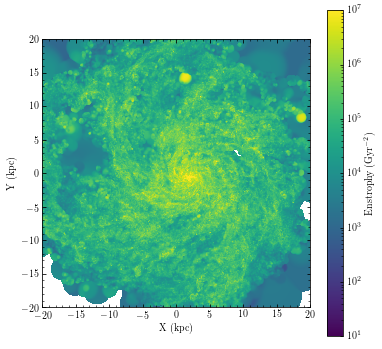

In [16]:
gradv = M.D(v)
enstrophy = np.sum(gradv*gradv, axis=(1,2))
enstrophy_projection = M.ProjectedAverage(enstrophy,center=np.array([0,0,0]),size=40.,res=res)
fig, ax = plt.subplots(figsize=(6,6))
p = ax.pcolormesh(X, Y, enstrophy_projection*.979**2, norm=colors.LogNorm(vmin=10,vmax=1e7))
fig.colorbar(p,label=r"Enstrophy $(\rm Gyr^{-2})$")
ax.set_aspect('equal')
ax.set_xlabel("X (kpc)")
ax.set_ylabel("Y (kpc)")
plt.show()